In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np 
from glob import glob 
import argparse
from helpers import *
from matplotlib import pyplot as plt 
# from tqdm import tqdm

import pickle


print("Import Done")

In [9]:
class ImageHelpers:
    def __init__(self):
        self.sift_object = cv2.xfeatures2d.SIFT_create()

    def gray(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return gray

    def features(self, image):
        keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
        return [keypoints, descriptors]


class BOVHelpers:
    def __init__(self, n_clusters=20):
        self.n_clusters = n_clusters
        self.kmeans_obj = KMeans(n_clusters=n_clusters)
        self.kmeans_ret = None
        self.descriptor_vstack = None
        self.mega_histogram = None
        self.clf = SVC()

    def cluster(self,person=""):
        print("Start clustering")
        self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)
        file=person+"Km.pkl"
        pickle.dump(self.kmeans_obj, open(file, 'wb'))

        
        
        print("clustering completed")
        print("\n##############################\n")


    def developVocabulary(self, n_images, descriptor_list):

        print("Start creating Mega Histogram")
        self.mega_histogram = np.array([np.zeros(self.n_clusters) for i in range(n_images)])
        old_count = 0
        for i in range(n_images):
            l = len(descriptor_list[i])
            for j in range(l):
                idx = self.kmeans_ret[old_count + j]
                self.mega_histogram[i][idx] += 1
            old_count += l
        print("Vocabulary mega Histogram Generated")
        print("\n##############################\n")


    def standardize(self, std=None):

        print("start standardization")
        if std is None:
            self.scale = StandardScaler().fit(self.mega_histogram)
            self.mega_histogram = self.scale.transform(self.mega_histogram)
        else:
            print("STD not none. External STD supplied")
            self.mega_histogram = std.transform(self.mega_histogram)
        print("standardization Completed")
        print("\n##############################\n")



    def formatND(self, l):
        """
		restructures list into vstack array of shape
		M samples x N features for sklearn

		"""
        print("Start Formatting")

        vStack = np.array(l[0])
        for remaining in l[1:]:
            vStack = np.vstack((vStack, remaining))
        self.descriptor_vstack = vStack.copy()
        print("Formatting completed")
        print("\n##############################\n")

        return

    def train(self, train_labels,person=""):
        print("Training SVM")
        print(self.clf)
        # print("Train labels", train_labels)
        self.clf.fit(self.mega_histogram, train_labels)
        gg=person+".sav"
        pickle.dump(self.clf, open(gg, 'wb'))

        print("Training completed")
        print("##############################")


    # def predict(self, iplist):
    #     predictions = self.clf.predict(iplist)
    #     return predictions

    def plotHist(self, vocabulary=None):
        print("Plotting histogram")
        if vocabulary is None:
            vocabulary = self.mega_histogram

        x_scalar = np.arange(self.n_clusters)
        y_scalar = np.array([abs(np.sum(vocabulary[:, h], dtype=np.int32)) for h in range(self.n_clusters)])

        # print(y_scalar)

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()


class FileHelpers:

    def __init__(self):
        pass

    def getFiles(self, path):
    
        imlist = {}
        count = 0
        for each in os.listdir(path):
            # hereeeeeeeeeeeeeeeeeeeeeee 1
            if not os.path.isdir(str(path+'\\'+each)):continue
            print("Reading image category ", each)
            imlist[each] = []
            for imagefile in os.listdir(path + '/' + each):
                # print("Reading file ", imagefile)
                im = cv2.imread(path + '/' + each + '/' + imagefile, 0)
                imlist[each].append(im)
                count += 1
        print("Reading completed")
        print("\n##############################\n")

        return [imlist, count]


class BOV:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bov_helper = BOVHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.descriptor_list = []




    def trainModel(self,person=""):

        self.images, self.trainImageCount = self.file_helper.getFiles(self.train_path)
        label_count = 0 
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            print ("Computing Features for ", word)
            for im in imlist:
                # cv2.imshow("im", im)
                # cv2.waitKey()
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)
            label_count += 1
        print("Training completed")
        print("##############################")

        self.bov_helper.formatND(self.descriptor_list)
        self.bov_helper.cluster(person)
        self.bov_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

        self.bov_helper.plotHist()

        self.bov_helper.standardize()
        self.bov_helper.train(self.train_labels,person)


    def recognize(self,test_img, test_image_path=None):

        kp, des = self.im_helper.features(test_img)
    
        vocab = np.array( [[ 0 for i in range(self.no_clusters)]])
        vocab = np.array(vocab, 'float32')

        test_ret = self.bov_helper.kmeans_obj.predict(des)

        for each in test_ret:
            vocab[0][each] += 1


        vocab = self.bov_helper.scale.transform(vocab)
        lb = self.bov_helper.clf.predict(vocab)
        return lb



    def testModel(self):

        correctClassifications = 0
        self.testImages, self.testImageCount = self.file_helper.getFiles(self.test_path)

        predictions = []

        for word, imlist in self.testImages.items():
            print ("processing " ,word)
            for im in imlist:
                cl = self.recognize(im)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))],
                    'actual':word
                    })

                if(self.name_dict[str(int(cl[0]))]==word):
                    correctClassifications = correctClassifications + 1

        print("Test Accuracy = " + str((correctClassifications/self.testImageCount) * 100))
        fig, axs = plt.subplots(2, 4)
        r=0
        c=0

        for each in predictions:
            axs[r, c].imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            axs[r, c].set_title("pred: "+each['object_name']+"\nact: "+each['actual'])
            c+=1
            if c==4:
                r=1
                c=0
            # plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            # plt.title("predicted : "+each['object_name']+" , actual : "+each['actual'])
        plt.show()
def test_script(self):
    gg='SignatureTestSamples'
    path=os.listdir(gg)
    images=[]
    labels_person=[]
    labels_check=[]
    print(path)
    
    for img in path:
        image_path=gg+"\\"+img
        size=(224,224)
        image = cv2.imread(image_path)
        image = cv2.resize(image,size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        if img.find('real')!=-1:
            labels_check.append(0)
        else: labels_check.append(1)
        
        
    predictions = []
    for im in images:
                cl = self.recognize(im)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))],
                    })

                if(self.name_dict[str(int(cl[0]))]==word):
                    correctClassifications = correctClassifications + 1

    
    print('Done')

print("Done")


Done


#########################
##### Start personA #####
#########################

Reading image category  forged
Reading image category  real
Reading completed

##############################

Computing Features for  forged
Computing Features for  real
Training completed
##############################
Start Formatting
Formatting completed

##############################

Start clustering


c:\Users\yousif mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clustering completed

##############################

Start creating Mega Histogram
Vocabulary mega Histogram Generated

##############################

Plotting histogram


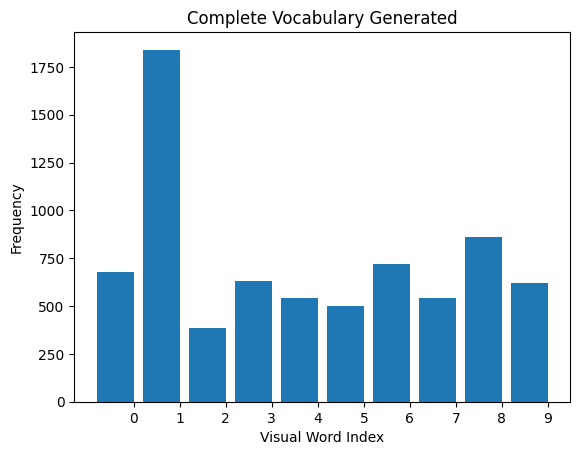

start standardization
standardization Completed

##############################

Training SVM
SVC()
Training completed
##############################
Reading image category  forged
Reading image category  real
Reading completed

##############################

processing  forged
processing  real
Test Accuracy = 71.42857142857143


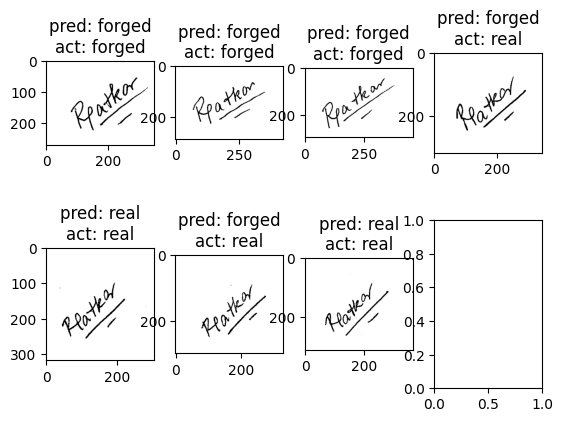



###################################################################


#########################
##### Start personB #####
#########################

Reading image category  forged
Reading image category  real
Reading completed

##############################

Computing Features for  forged
Computing Features for  real
Training completed
##############################
Start Formatting
Formatting completed

##############################

Start clustering


c:\Users\yousif mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clustering completed

##############################

Start creating Mega Histogram
Vocabulary mega Histogram Generated

##############################

Plotting histogram


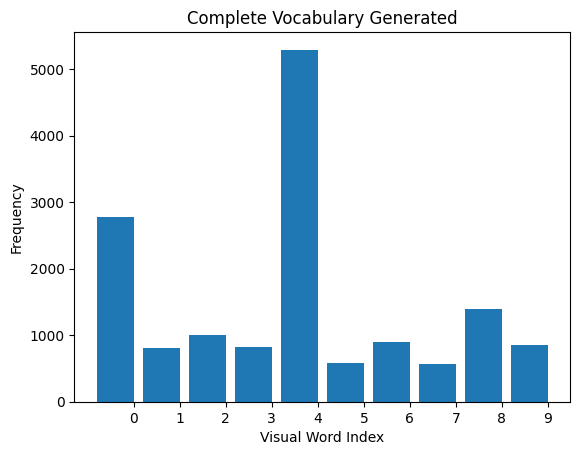

start standardization
standardization Completed

##############################

Training SVM
SVC()
Training completed
##############################
Reading image category  forged
Reading image category  real
Reading completed

##############################

processing  forged
processing  real
Test Accuracy = 100.0


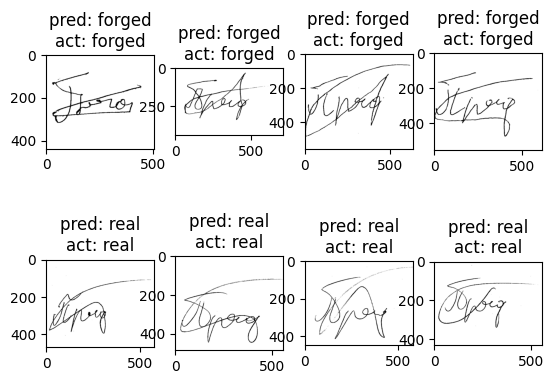



###################################################################


#########################
##### Start personC #####
#########################

Reading image category  forged
Reading image category  real
Reading completed

##############################

Computing Features for  forged
Computing Features for  real
Training completed
##############################
Start Formatting
Formatting completed

##############################

Start clustering


c:\Users\yousif mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clustering completed

##############################

Start creating Mega Histogram
Vocabulary mega Histogram Generated

##############################

Plotting histogram


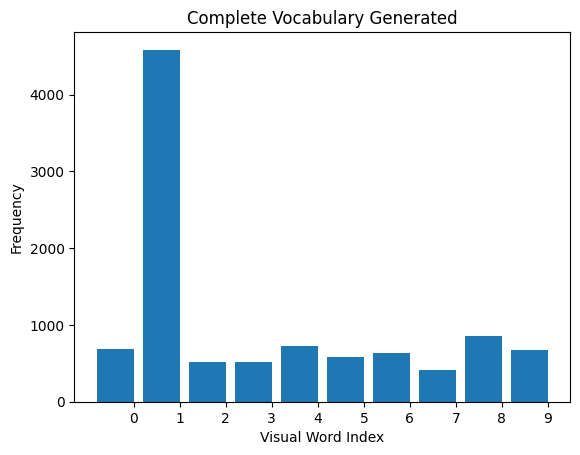

start standardization
standardization Completed

##############################

Training SVM
SVC()
Training completed
##############################
Reading image category  forged
Reading image category  real
Reading completed

##############################

processing  forged
processing  real
Test Accuracy = 100.0


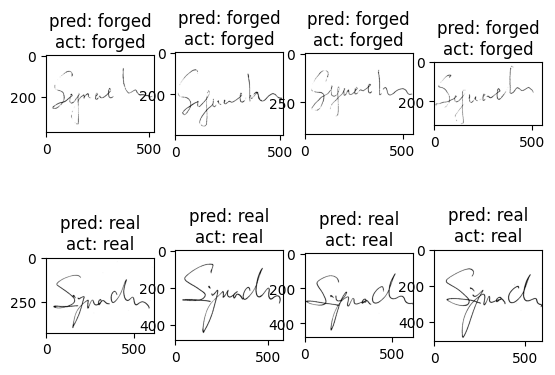



###################################################################


#########################
##### Start personD #####
#########################

Reading image category  forged
Reading image category  real
Reading completed

##############################

Computing Features for  forged
Computing Features for  real
Training completed
##############################
Start Formatting
Formatting completed

##############################

Start clustering


c:\Users\yousif mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clustering completed

##############################

Start creating Mega Histogram
Vocabulary mega Histogram Generated

##############################

Plotting histogram


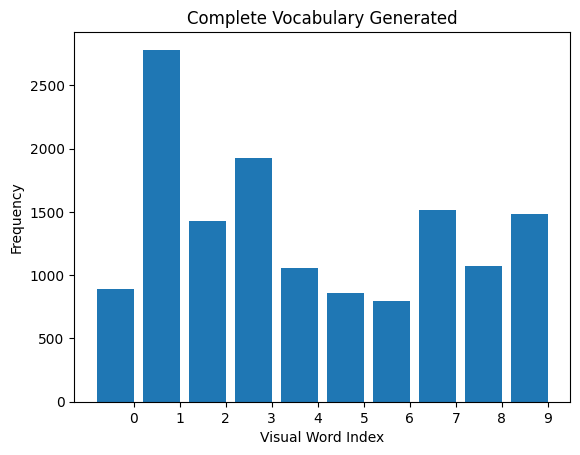

start standardization
standardization Completed

##############################

Training SVM
SVC()
Training completed
##############################
Reading image category  forged
Reading image category  real
Reading completed

##############################

processing  forged
processing  real
Test Accuracy = 87.5


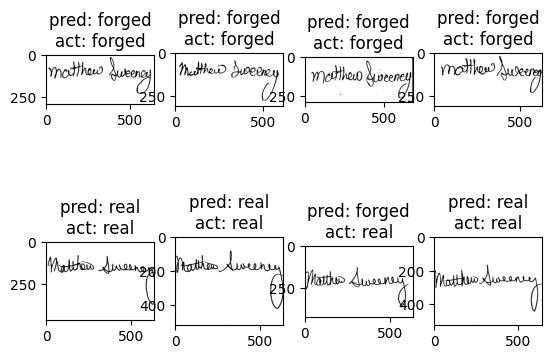



###################################################################


#########################
##### Start personE #####
#########################

Reading image category  forged
Reading image category  real
Reading completed

##############################

Computing Features for  forged
Computing Features for  real
Training completed
##############################
Start Formatting
Formatting completed

##############################

Start clustering


c:\Users\yousif mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clustering completed

##############################

Start creating Mega Histogram
Vocabulary mega Histogram Generated

##############################

Plotting histogram


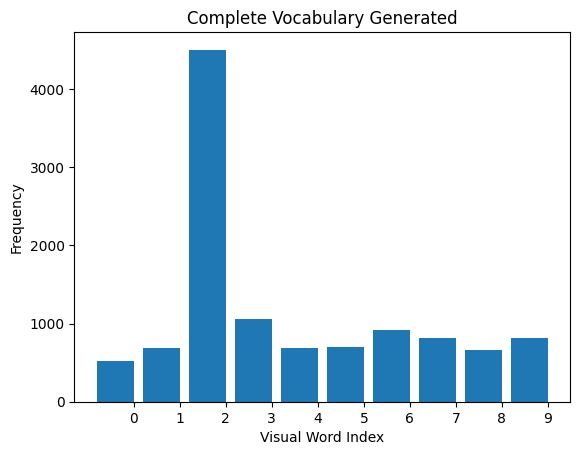

start standardization
standardization Completed

##############################

Training SVM
SVC()
Training completed
##############################
Reading image category  forged
Reading image category  real
Reading completed

##############################

processing  forged
processing  real
Test Accuracy = 100.0


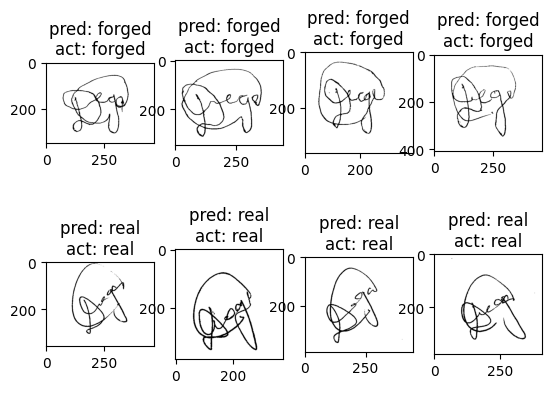



###################################################################




In [10]:
def gg(s):
    n=5
    print((2*n+len(s)+2)*'#')

    print(n*'#',end=' ')
    print(s,end=' ')
    print(n*'#')
    
    print((2*n+len(s)+2)*'#')


persons=os.listdir('CV_2023_SC_Dataset')
for person in persons:
    gg("Start "+person)
    print()
    bov = BOV(no_clusters=10)
    bov.train_path = "CV_2023_SC_Dataset\\"+person+"\\Train"
    bov.test_path =  "CV_2023_SC_Dataset\\"+person+"\\Test"
    bov.trainModel(person)
    bov.testModel()
    print("\n\n###################################################################\n\n")

    





In [ ]:
person="personA"
bov = BOV(no_clusters=10)
bov.train_path = "CV_2023_SC_Dataset\\"+person+"\\Train"
bov.test_path =  "CV_2023_SC_Dataset\\"+person+"\\Test"
bov.trainModel(person)